# Emoji Classification Challenge

## Objective
Identify the visual origin/vendor of emoji images based on their style characteristics.

**Classes**: apple, facebook, google, messenger, samsung, whatsapp

## Approach
This notebook implements a Convolutional Neural Network (CNN) to classify emojis by their visual style. The solution includes:
- Custom CNN architecture optimized for small images
- Data augmentation for better generalization
- Proper train/validation split
- Comprehensive evaluation and visualization

## Imports
### Libraries

In [17]:
import os
import numpy as np
import pandas as pd 

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]: # I print 5 files per folder
        print(os.path.join(dirname, filename))

## ⚠️ Windows Long Path Issue

**Problem:** TensorFlow cannot be installed on Windows due to path length limitations.

**Solution Options:**

### Option 1: Enable Windows Long Paths (Recommended)
1. Open **PowerShell as Administrator**
2. Run this command:
```powershell
New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
```
3. **Restart your computer**
4. Run the cell below to install TensorFlow

### Option 2: Use Anaconda/Miniconda
```bash
conda install tensorflow
```

### Option 3: Use Keras with JAX backend (Current Workaround)
The installation cell below uses Keras with JAX, which avoids the path issue.

**After running the installation cell, restart the kernel (Kernel → Restart Kernel) before proceeding.**

In [18]:
# Clean install of Keras with JAX backend
%pip uninstall -y keras tensorflow keras-cv keras-nlp
%pip install --upgrade "keras==3.12.0" "jax[cpu]==0.4.35" "jaxlib==0.4.35"
print("✓ Installation complete. Kernel restart may be required.")

Found existing installation: keras 3.13.0
Uninstalling keras-3.13.0:
  Successfully uninstalled keras-3.13.0
Note: you may need to restart the kernel to use updated packages.


  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 8.1 MB/s  0:00:00
   ---------------------------------------- 0.0/56.5 MB ? eta -:--:--
    --------------------------------------- 1.0/56.5 MB 25.4 MB/s eta 0:00:03
    --------------------------------------- 1.0/56.5 MB 25.4 MB/s eta 0:00:03
    --------------------------------------- 1.0/56.5 MB 25.4 MB/s eta 0:00:03
    --------------------------------------- 1.0/56.5 MB 25.4 MB/s eta 0:00:03
   - -------------------------------------- 2.1/56.5 MB 2.0 MB/s eta 0:00:28
   -- ------------------------------------- 3.1/56.5 MB 2.4 MB/s eta 0:00:23
   -- ------------------------------------- 4.2/56.5 MB 2.8 MB/s eta 0:00:19
   -- ------------------------------------- 4.2/56.5 MB 2.8 M

  You can safely remove it manually.


In [19]:
# Fix numpy version compatibility
%pip install "numpy>=1.24,<2.3"

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 4.2 MB/s eta 0:00:03
   ----------------- ---------------------- 5.5/12.9 MB 18.7 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 28.8 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 20.8 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.5.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.2.6 which is incompatible.


In [ ]:
from pathlib import Path
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
import os

# Configure Keras to use JAX backend
os.environ['KERAS_BACKEND'] = 'jax'

# Import Keras (should use JAX backend now)
import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print(f"✓ Using Keras {keras.__version__} with backend: {keras.backend.backend()}")

✓ Using Keras 3.12.0 with backend: jax


### Functions

In [21]:
def load_single_image(path, target_size=(72, 72)):
    """
    Load and preprocess a single image.
    - Converts to RGB
    - Resizes to target_size
    - Normalizes to [0, 1]
    """
    img = Image.open(path).convert("RGBA")
    img = np.array(img)

    # RGBA -> RGB
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img) 
    # grayscale -> RGB
    elif img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # uint8 conversion
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Resize to consistent size
    img = Image.fromarray(img)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = np.array(img)

    return img.astype("float32") / 255.0


def create_dataset(files, labels_dict, label_encoder, target_size=(72, 72)):
    """
    Create complete dataset in memory (for smaller datasets).
    """
    X = []
    y = []
    
    for file_path in files:
        img_id = Path(file_path).stem
        img = load_single_image(file_path, target_size)
        X.append(img)
        
        label = labels_dict[img_id]
        encoded_label = label_encoder.transform([label])[0]
        y.append(encoded_label)
    
    return np.array(X), np.array(y)


def imageLoader(files, labels, label_encoder, batch_size, target_size=(72, 72)):
    """
    Generator for learning by batches.
    """
    L = len(files)

    while True: 
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Batch files (slices)
            batch_files = files[batch_start:limit]

            X_batch = []
            y_batch = []

            for f in batch_files:
                img_id = Path(f).stem
                img = load_single_image(f, target_size)
                X_batch.append(img)
                
                label = labels[img_id]
                encoded_label = label_encoder.transform([label])[0]
                y_batch.append(encoded_label)

            X = np.stack(X_batch)
            Y = np.array(y_batch)

            yield X, Y

            batch_start += batch_size
            batch_end += batch_size

### Dataset

In [22]:
PATH = ""

In [23]:
train_dir = Path(PATH + "train/")
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])

In [24]:
test_dir = Path(PATH + "test/")
test_files = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids = [Path(f).stem for f in test_files]

In [28]:
y_train_df = pd.read_csv(PATH+ "train_labels.csv")

# Convert IDs to 5-digit zero-padded strings to match file names
y_train_dct = dict(zip(y_train_df["Id"].astype(str).str.zfill(5), y_train_df["Label"]))

### Data Exploration

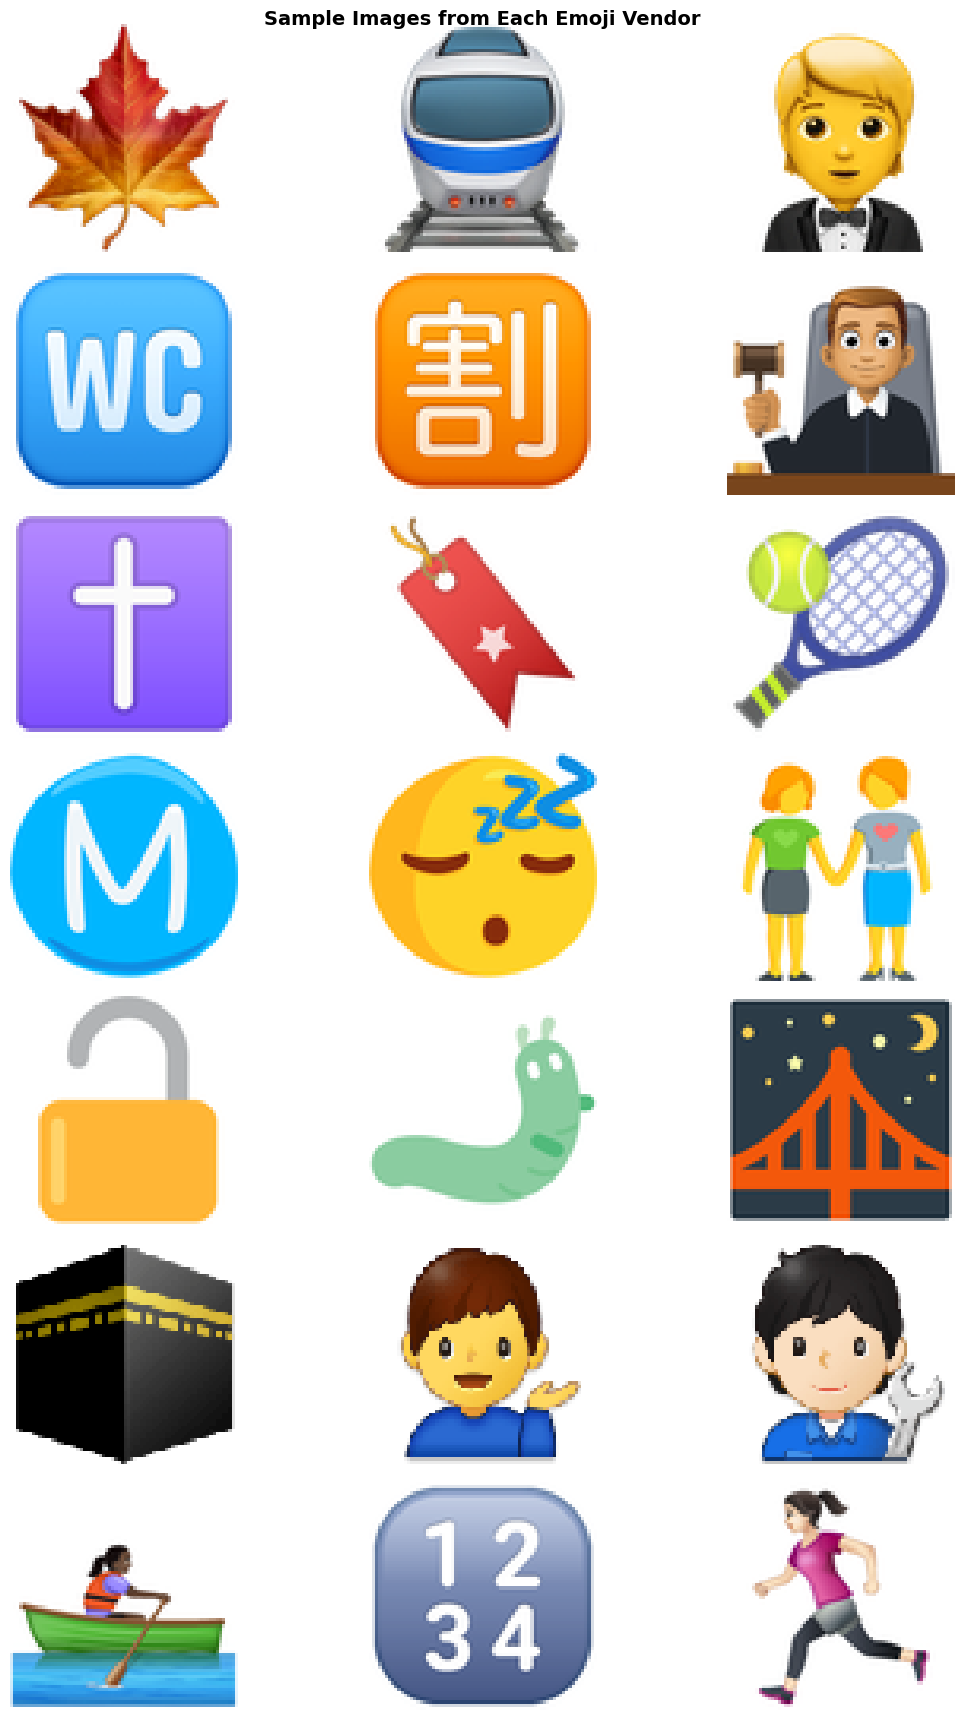

In [29]:
# Visualize sample images from each class
def show_sample_images_per_class(train_files, labels_dict, num_per_class=3):
    """
    Display sample images from each emoji class.
    """
    # Get unique labels
    unique_labels = sorted(set(labels_dict.values()))
    
    fig, axes = plt.subplots(len(unique_labels), num_per_class, 
                             figsize=(12, 2.5 * len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        # Find files for this label
        label_files = [f for f in train_files if labels_dict[Path(f).stem] == label]
        
        # Select random samples
        sample_files = np.random.choice(label_files, 
                                       min(num_per_class, len(label_files)), 
                                       replace=False)
        
        for j, file_path in enumerate(sample_files):
            img = load_single_image(file_path)
            axes[i, j].imshow(img)
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=12, fontweight='bold')
            axes[i, j].axis('off')
            
        # Fill empty subplots if needed
        for j in range(len(sample_files), num_per_class):
            axes[i, j].axis('off')
    
    plt.suptitle('Sample Images from Each Emoji Vendor', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_sample_images_per_class(train_files, y_train_dct)

In [34]:
# Prepare label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_df["Label"])

print("Classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))

# Check class distribution
print("\nClass distribution:")
print(y_train_df["Label"].value_counts())

Classes: ['apple' 'facebook' 'google' 'messenger' 'mozilla' 'samsung' 'whatsapp']
Number of classes: 7

Class distribution:
Label
apple        1924
google       1877
samsung      1790
facebook     1667
whatsapp     1644
messenger     580
mozilla       397
Name: count, dtype: int64


In [36]:
# Split data into training and validation sets
train_files_split, val_files_split = train_test_split(
    train_files, 
    test_size=0.15, 
    random_state=42,
    stratify=[y_train_dct[Path(f).stem] for f in train_files]
)

print(f"Training samples: {len(train_files_split)}")
print(f"Validation samples: {len(val_files_split)}")

Training samples: 8397
Validation samples: 1482


## Model Architecture

In [ ]:
def build_cnn_model(input_shape=(72, 72, 3), num_classes=6):
    """
    Build a CNN model for emoji classification.
    Architecture optimized for small emoji images.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_cnn_model(num_classes=len(label_encoder.classes_))

# Compile with appropriate optimizer and loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

AttributeError: module 'keras.src.backend' has no attribute 'name_scope'

## Data Augmentation

In [ ]:
# Data augmentation is now built into the model using Keras 3 preprocessing layers:
# - RandomFlip (horizontal)
# - RandomRotation (~15 degrees)
# - RandomZoom (10%)
# These layers are only active during training, not during inference.

print("✓ Data augmentation is configured in the model architecture")

In [ ]:
# Load training and validation data into memory
print("Loading training data...")
X_train, y_train = create_dataset(train_files_split, y_train_dct, label_encoder)
print(f"Training data loaded: {X_train.shape}")

print("Loading validation data...")
X_val, y_val = create_dataset(val_files_split, y_train_dct, label_encoder)
print(f"Validation data loaded: {X_val.shape}")

## Training

In [ ]:
# Define callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_emoji_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured successfully")

In [ ]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 50

print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [ ]:
# Plot training history
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

## Model Evaluation

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions on validation set for confusion matrix
val_predictions = model.predict(X_val, verbose=0)
val_pred_labels = np.argmax(val_predictions, axis=1)

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_val, val_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_pred_labels, 
                          target_names=label_encoder.classes_))

In [ ]:
# Visualize some sample predictions
def visualize_predictions(files, predictions, label_encoder, num_samples=12):
    """
    Visualize random sample predictions.
    """
    indices = np.random.choice(len(files), min(num_samples, len(files)), replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = load_single_image(files[idx])
        pred_label = predictions[idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {pred_label}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize validation set predictions
val_predictions_labels = label_encoder.inverse_transform(val_pred_labels)
visualize_predictions(val_files_split, val_predictions_labels, label_encoder)

## Predictions on Test Set

In [ ]:
def predict_with_trained_model(model, test_files, label_encoder, batch_size=32):
    """
    Make predictions on test data using the trained model.
    """
    predictions = []
    
    # Process in batches for efficiency
    for i in range(0, len(test_files), batch_size):
        batch_files = test_files[i:i+batch_size]
        batch_images = []
        
        for file_path in batch_files:
            img = load_single_image(file_path)
            batch_images.append(img)
        
        batch_images = np.array(batch_images)
        
        # Get predictions
        batch_preds = model.predict(batch_images, verbose=0)
        batch_labels = np.argmax(batch_preds, axis=1)
        
        # Decode labels
        batch_labels_decoded = label_encoder.inverse_transform(batch_labels)
        predictions.extend(batch_labels_decoded)
    
    return np.array(predictions)

# Make predictions on test set
print("Making predictions on test set...")
y_test_pred = predict_with_trained_model(model, test_files, label_encoder)
print(f"Predictions completed for {len(y_test_pred)} test samples")

# Show prediction distribution
unique, counts = np.unique(y_test_pred, return_counts=True)
print("\nPrediction distribution:")
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")

array(['mozilla', 'google', 'facebook', ..., 'samsung', 'facebook',
       'facebook'], dtype='<U9')

In [ ]:
test_ids_sr = pd.Series(test_ids, name="Id")
y_test_pred_sr = pd.Series(y_test_pred, name="Label")
submission_df = pd.concat([test_ids_sr, y_test_pred_sr], axis=1)
submission_df.head()

,Id,Label
0,10001,mozilla
1,10002,google
2,10003,facebook
3,10004,samsung
4,10005,google


## Create Submission File

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
# Verify submission file
print("Submission file preview:")
print(submission_df.head(10))
print(f"\nTotal submissions: {len(submission_df)}")
print(f"\nSubmission saved to: submission.csv")

# Check for any issues
assert len(submission_df) == len(test_files), "Mismatch in number of predictions!"
assert all(submission_df["Label"].isin(label_encoder.classes_)), "Invalid labels detected!"
print("\n✓ Submission file validated successfully!")

## Summary

### Model Architecture
- **CNN-based architecture** with 3 convolutional blocks
- Each block contains:
  - 2 Conv2D layers with batch normalization
  - MaxPooling for downsampling
  - Dropout for regularization
- Dense layers with 256 and 128 neurons
- **Total classes**: 6 emoji vendors (apple, facebook, google, messenger, samsung, whatsapp)

### Training Strategy
- **Data augmentation**: rotation, shifts, zoom, horizontal flip
- **Train/validation split**: 85/15 stratified split
- **Optimizer**: Adam with learning rate 0.001
- **Callbacks**: 
  - Early stopping (patience=10)
  - Learning rate reduction on plateau
  - Model checkpointing

### Key Features
- Proper image preprocessing (RGBA→RGB, resizing, normalization)
- Label encoding for multi-class classification
- Comprehensive evaluation metrics (confusion matrix, classification report)
- Visualization of training progress and predictions

### Next Steps for Improvement
1. **Transfer Learning**: Use pre-trained models (MobileNet, EfficientNet)
2. **Ensemble Methods**: Combine multiple models
3. **Advanced Augmentation**: Use techniques like mixup, cutmix
4. **Hyperparameter Tuning**: Optimize learning rate, batch size, architecture
5. **Cross-Validation**: Use K-fold for more robust evaluation